In [15]:
import time
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import reduce
from tqdm import tqdm


In [16]:
path = 'large-txt.txt'

with open(path, 'r', encoding='latin') as f:
    lines = f.readlines()
print(f"Total lines: {len(lines)}")

Total lines: 2225370


In [17]:
def word_count_single_processor(data_lines):
    """
    Compte les occurrences des mots en utilisant un seul processeur sans utiliser de bibliothèques externes.
    Mesure et retourne le temps écoulé.
    """
    start_time = time.time()
    word_counts = {}

    for line in data_lines:
        words = line.split()
        for word in words:
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1

    end_time = time.time()
    elapsed_time = end_time - start_time
    return word_counts, elapsed_time

In [18]:
single_counts, single_time = word_count_single_processor(lines)
print(f"Processeur Simple Temps: {single_time:.4f} secondes")
print(f"Nombre de mots uniques (Processeur simple): {len(single_counts)}")

Processeur Simple Temps: 4.1156 secondes
Nombre de mots uniques (Processeur simple): 615470


In [19]:
def split_into_chunks(data_lines, num_chunks):
    """
    Splits the list of lines into num_chunks chunks.
    Returns a list of chunk strings.
    """
    chunk_size = len(data_lines) // num_chunks
    chunks = []
    start = 0
    for i in range(num_chunks):
        if i == num_chunks - 1:
            chunk_lines = data_lines[start:]
        else:
            chunk_lines = data_lines[start : start + chunk_size]
        start += chunk_size
        chunks.append(" ".join(chunk_lines))
    return chunks

def map_function(text_chunk):
    """Fonction de map : retourne un dictionnaire des fréquences de mots pour le morceau de texte."""
    word_freq = {}
    for word in text_chunk.split():
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1
    return word_freq

def reduce_function(counter_a, counter_b):
    """Reduce function: merges two word count dictionaries by summing counts."""
    for word, count in counter_b.items():
        if word in counter_a:
            counter_a[word] += count
        else:
            counter_a[word] = count
    return counter_a

def word_count_multiprocess(data_lines, processes=2):
    """
    Counts word occurrences using multiple processors.
    Measures and returns the time taken for each stage and the final counts.
    """
    timings = {}
    t_start_total = time.time()

    # Chunking
    t_start_chunk = time.time()
    chunks = split_into_chunks(data_lines, num_chunks=processes)
    t_end_chunk = time.time()
    timings['time_chunk'] = t_end_chunk - t_start_chunk

    # Mapping
    t_start_map = time.time()
    with multiprocessing.Pool(processes=processes) as pool:
        partial_counters = pool.map(map_function, chunks)
    t_end_map = time.time()
    timings['time_map'] = t_end_map - t_start_map

    # Reducing
    t_start_reduce = time.time()
    final_counts = reduce(reduce_function, partial_counters)
    t_end_reduce = time.time()
    timings['time_reduce'] = t_end_reduce - t_start_reduce

    t_end_total = time.time()
    timings['time_total'] = t_end_total - t_start_total

    return final_counts, timings

In [20]:
# Define processor configurations and number of runs
process_list = [2, 3, 4]
N_RUNS = 5

all_results = []

for procs in process_list:
    print(f"\nNb process: {procs}")
    for run in tqdm(range(1, N_RUNS + 1), desc=f"Runs for {procs} processes"):
        counts, timings = word_count_multiprocess(lines, processes=procs)
        result = {'processes': procs,
                  'run': run,
                  'time_chunk': timings['time_chunk'],
                  'time_map': timings['time_map'],
                  'time_reduce': timings['time_reduce'],
                  'time_total': timings['time_total']}
        all_results.append(result)


Nb process: 2


Runs for 2 processes: 100%|██████████| 5/5 [00:21<00:00,  4.22s/it]



Nb process: 3


Runs for 3 processes: 100%|██████████| 5/5 [00:17<00:00,  3.55s/it]



Nb process: 4


Runs for 4 processes: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]


In [21]:
SINGLE_N_RUNS = 5

single_results = []
for run in tqdm(range(1, SINGLE_N_RUNS + 1), desc="Process unique"):
    _, single_time = word_count_single_processor(lines)
    result = {'processes': 1,
              'run': run,
              'time_chunk': None,  # Not applicable
              'time_map': None,    # Not applicable
              'time_reduce': None, # Not applicable
              'time_total': single_time}
    single_results.append(result)

all_results.extend(single_results)

Process unique: 100%|██████████| 5/5 [00:21<00:00,  4.32s/it]


In [22]:
# Convert all results to a pandas DataFrame
df_results = pd.DataFrame(all_results)
df_results.head(10)

,processes,run,time_chunk,time_map,time_reduce,time_total
0,2,1,0.153752,3.703662,0.116477,3.973960
1,2,2,0.188069,3.899866,0.135001,4.223004
2,2,3,0.196265,3.831118,0.146253,4.173651
3,2,4,0.191865,3.884833,0.151025,4.227937
4,2,5,0.187644,3.851423,0.149917,4.189079
5,3,1,0.196847,3.071372,0.199725,3.467963
6,3,2,0.197934,2.957181,0.210363,3.365496
7,3,3,0.187545,3.080615,0.266920,3.535093
8,3,4,0.205945,3.054234,0.221186,3.481739
9,3,5,0.192154,3.138490,0.226324,3.556979


In [24]:
# Statistical Summary
print("\nStats resume (secondes):")
df_results.groupby('processes').agg(['mean', 'std'])


Stats resume (secondes):


run           time_chunk            time_map           time_reduce  \
          mean       std       mean       std      mean       std        mean   
processes                                                                       
1          3.0  1.581139        NaN       NaN       NaN       NaN         NaN   
2          3.0  1.581139   0.183519  0.016999  3.834181  0.077817    0.139735   
3          3.0  1.581139   0.196085  0.006885  3.060378  0.065801    0.224903   
4          3.0  1.581139   0.200332  0.006629  2.700683  0.057641    0.274520   

                    time_total            
                std       mean       std  
processes                                 
1               NaN   4.300920  0.081642  
2          0.014465   4.157526  0.105116  
3          0.025625   3.481454  0.074514  
4          0.008019   3.175566  0.059965

/tmp/ipykernel_83123/2730941705.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='processes', y='time_total', data=df_results, palette="Set2")


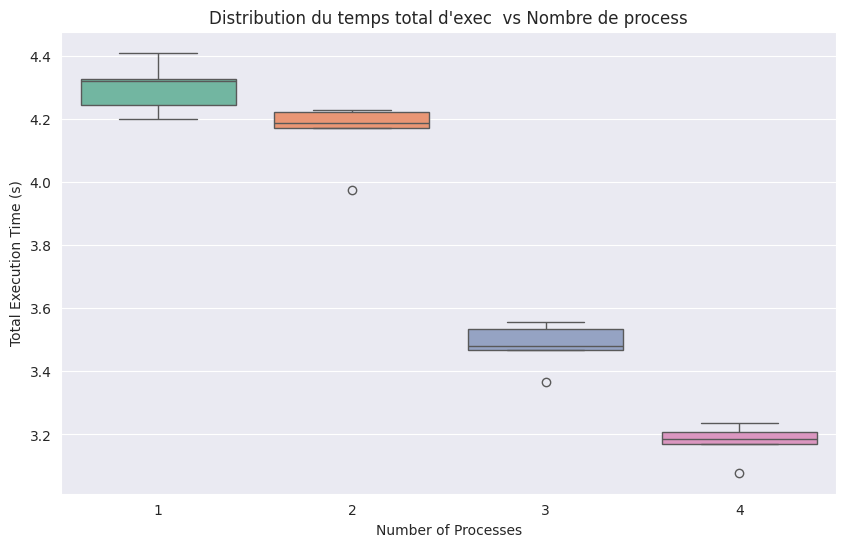

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='processes', y='time_total', data=df_results, palette="Set2")
plt.title("Distribution du temps total d'exec  vs Nombre de process")
plt.xlabel("Number of Processes")
plt.ylabel("Total Execution Time (s)")
plt.show()

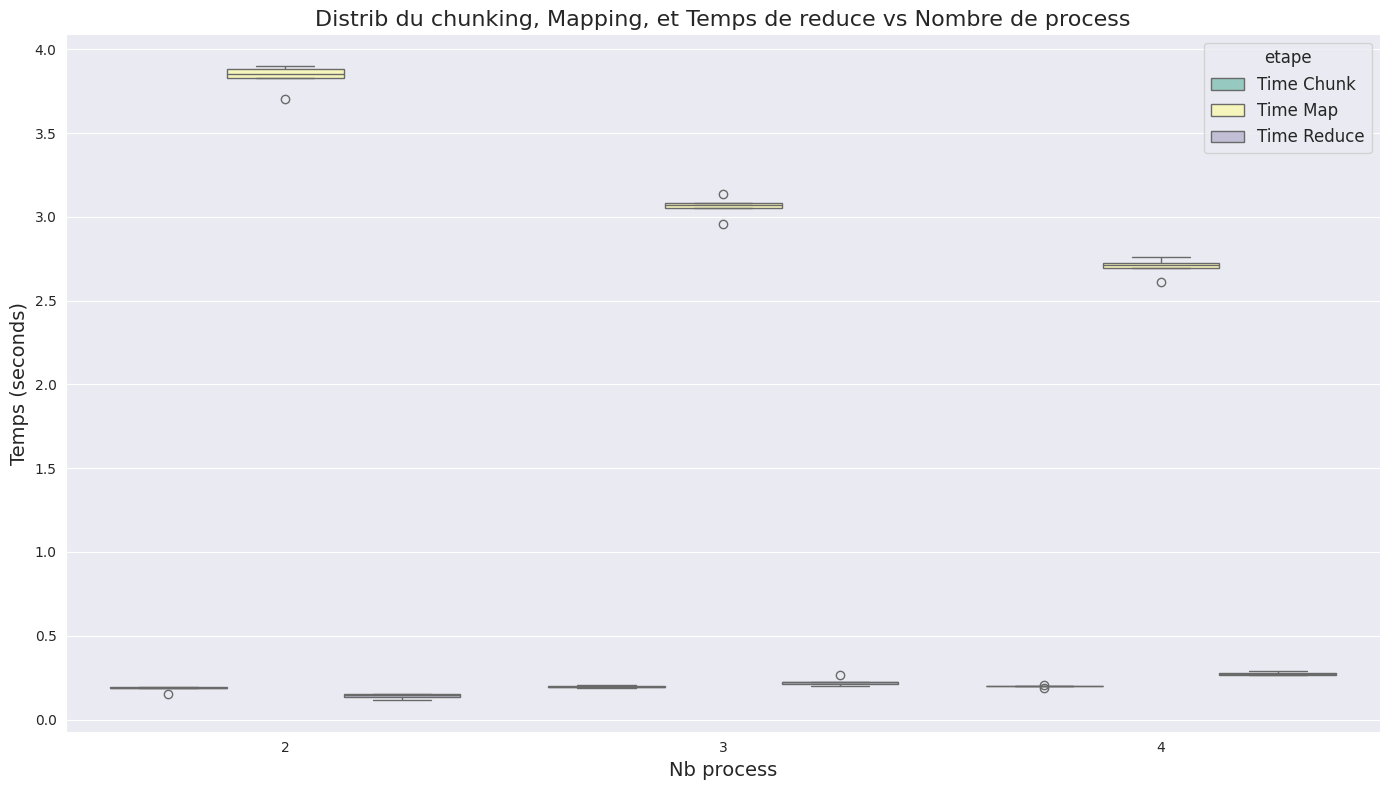

In [26]:
df_multi = df_results[df_results['processes'].isin([2, 3, 4])]

df_melted = df_multi.melt(
    id_vars=['processes', 'run'],
    value_vars=['time_chunk', 'time_map', 'time_reduce'],
    var_name='stage',
    value_name='time'
)

df_melted['stage'] = df_melted['stage'].str.replace('_', ' ').str.title()

plt.figure(figsize=(14, 8))
sns.boxplot(
    x='processes',
    y='time',
    hue='stage',
    data=df_melted,
    palette="Set3"
)
plt.title("Distrib du chunking, Mapping, et Temps de reduce vs Nombre de process", fontsize=16)
plt.xlabel("Nb process", fontsize=14)
plt.ylabel("Temps (seconds)", fontsize=14)
plt.legend(title="etape", fontsize=12, title_fontsize=12)
plt.tight_layout()
plt.show()